In [1]:
#######################################################
#######################################################
############    COPYRIGHT - DATA SOCIETY   ############
#######################################################
#######################################################

## OUTLIER DETECTION DAY 3/OUTLIER DETECTION PART 5 ##

## NOTE: To run individual pieces of code, select the line of code and
##       press ctrl + enter for PCs or command + enter for Macs




In [2]:
#=================================================-
#### Slide 4: Import packages  ####

import os
from pathlib import Path
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error




In [3]:
#=================================================-
#### Slide 5: Directory settings  ####

# Set 'main_dir' to location of the project folder
from pathlib import Path 
home_dir = Path(".").resolve()
main_dir = home_dir.parent
print(main_dir)
data_dir = str(main_dir) + "/data"
print(data_dir)




/Users/swaroopnc/Downloads/SkillAnamoly2025
/Users/swaroopnc/Downloads/SkillAnamoly2025/data


In [4]:
#=================================================-
#### Slide 6: Load PJM Energy dataset  ####

pjm_energy = pd.read_csv(str(data_dir) + "/PJME_hourly.csv")
print(pjm_energy.head())
pjm_energy['Datetime'] = pd.to_datetime(pjm_energy['Datetime'])
pjm_energy.dtypes




              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0


Datetime    datetime64[ns]
PJME_MW            float64
dtype: object

In [5]:
#=================================================-
#### Slide 7: Extract Date from Datetime  ####

pjm_energy = pjm_energy.sort_values(by=['Datetime'])
pjm_energy = pjm_energy[pjm_energy['Datetime'] > '2018-01-01 00:00:00']
pjm_energy.shape
pjm_energy['Date'] = pjm_energy['Datetime'].dt.date
pjm_energy_datewise = pjm_energy.groupby(by=['Date'])['PJME_MW'].mean()




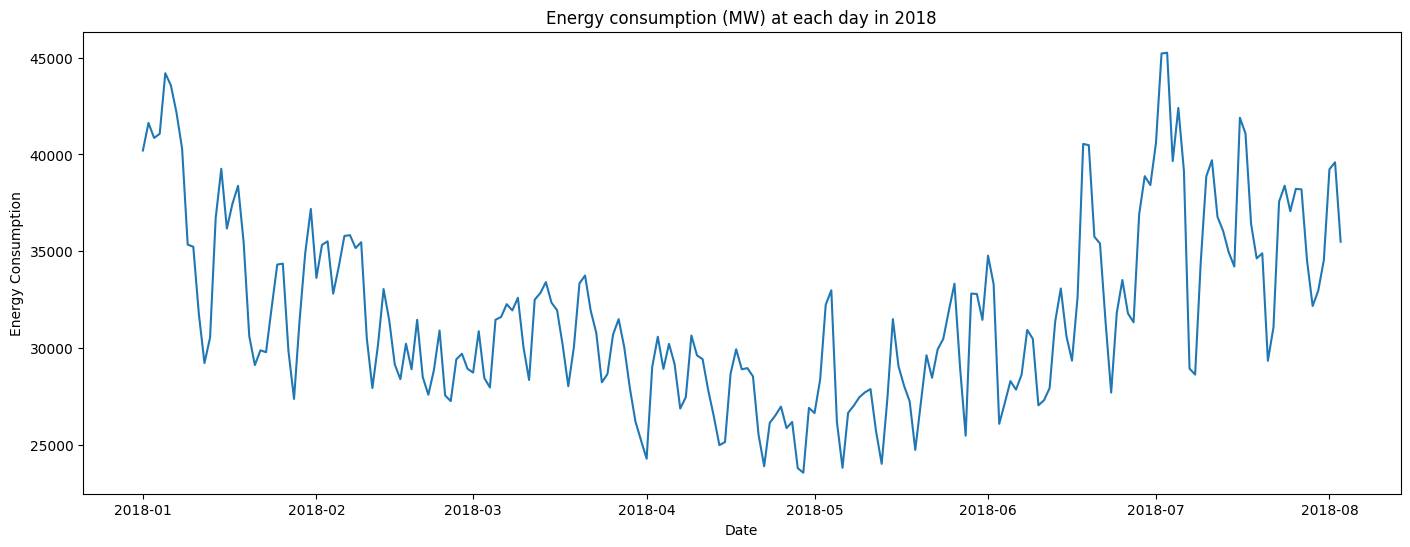

In [6]:
#=================================================-
#### Slide 8: Visualize the Energy consumption for each day  ####

pjm_energy_datewise.plot(x='Date', y='PJME_MW', figsize=(17,6))
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Energy consumption (MW) at each day in 2018')
plt.show()




In [7]:
#=================================================-
#### Slide 16: Stationarity test  ####

# Perform ADF test on original series.
result_pm = adfuller(pjm_energy_datewise)

print('ADF Statistic: %f' % result_pm[0])
print('p-value: %f' % result_pm[1])




ADF Statistic: -1.625863
p-value: 0.469657


In [8]:
#=================================================-
#### Slide 18: Fitting ARIMA model  ####

# Set up ARIMA model using train data only.
arima = ARIMA(pjm_energy_datewise, order = (5, 1, 0))
# Fit ARIMA model to train data only.
arima_fit = arima.fit()




/Users/swaroopnc/miniforge3/envs/skill_anamoly_2025/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/swaroopnc/miniforge3/envs/skill_anamoly_2025/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/swaroopnc/miniforge3/envs/skill_anamoly_2025/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


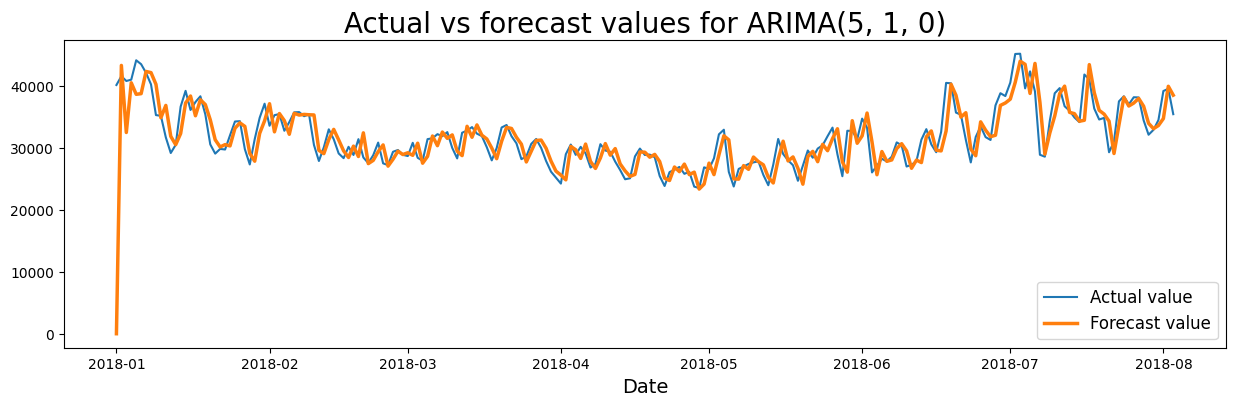

In [9]:
#=================================================-
#### Slide 19: Forecast vs. Actual Plot   ####

# Fitted values.
predicted = arima_fit.predict(typ='levels')
fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(pjm_energy_datewise, linestyle = '-', linewidth = 1.5, label = 'Actual value')
ax.plot(predicted, markersize = 5, linewidth = 2.5, linestyle = '-',label = 'Forecast value')
ax.set_xlabel('Date', fontsize = 14)
ax.set_title("Actual vs forecast values for ARIMA(5, 1, 0)", fontsize = 20)
ax.legend(loc='best', fontsize=12)




In [10]:
#=================================================-
#### Slide 22: Calculate error and static threshold  ####

results = pd.DataFrame(pjm_energy_datewise)
results['predicted'] = predicted
results['error'] = abs(results['PJME_MW'] - results['predicted'])
results['static_threshold'] = np.mean(results['error']) + 3 * np.std(results['error'])
results['static_anomaly'] = results['error'] >= results['static_threshold']
results.head()




PJME_MW     predicted         error  static_threshold  \
Date                                                                     
2018-01-01  40202.478261      0.000000  40202.478261      11206.393734   
2018-01-02  41627.333333  43364.125363   1736.792029      11206.393734   
2018-01-03  40852.750000  32530.874224   8321.875776      11206.393734   
2018-01-04  41065.000000  40562.812578    502.187422      11206.393734   
2018-01-05  44197.791667  38698.456659   5499.335007      11206.393734   

            static_anomaly  
Date                        
2018-01-01            True  
2018-01-02           False  
2018-01-03           False  
2018-01-04           False  
2018-01-05           False

In [11]:
#=================================================-
#### Slide 23: Anomalies detected with static threshold  ####

results['static_anomaly'].value_counts()
results[results['static_anomaly'] == True]




PJME_MW  predicted         error  static_threshold  \
Date                                                                  
2018-01-01  40202.478261        0.0  40202.478261      11206.393734   

            static_anomaly  
Date                        
2018-01-01            True

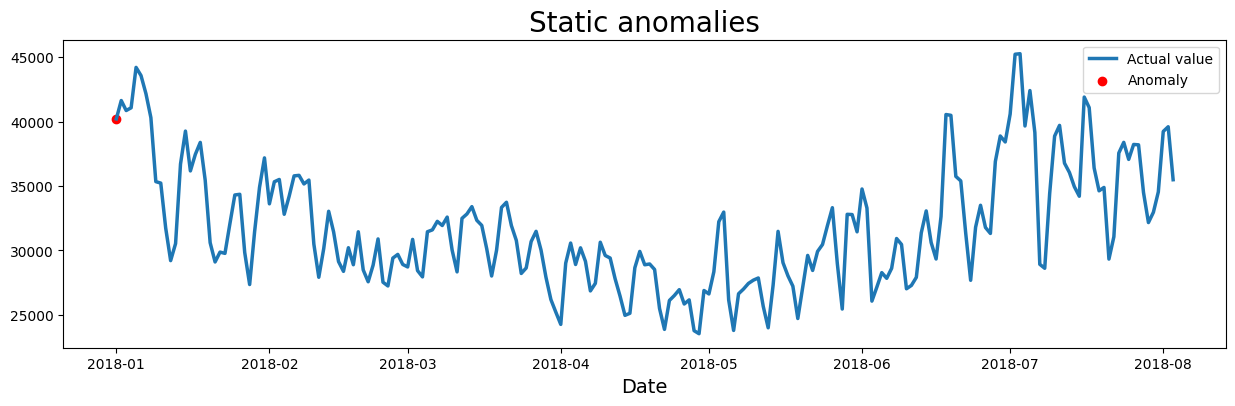

In [12]:
#=================================================-
#### Slide 24: Visualize the anomalies  ####

fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(results['PJME_MW'],markersize = 5, linewidth = 2.5, linestyle = '-', 
        label = 'Actual value')
ax.scatter(results[results['static_anomaly'] == True].index,results[results['static_anomaly'] == True]['PJME_MW'], 
        color='red',label = 'Anomaly')
ax.set_xlabel('Date', fontsize = 14)
ax.set_title("Static anomalies", fontsize = 20)
ax.legend()
plt.show()




In [13]:
#=================================================-
#### Slide 25: Calculate dynamic threshold  ####

results['error_windowed_mean'] = results['error'].rolling(window=7, min_periods=1).mean()
results['error_windowed_std'] = results['error'].rolling(window=7, min_periods=1).std()
results['dynamic_threshold'] = results['error_windowed_mean'] + (2*results['error_windowed_std'])
results['dynamic_anomaly'] = results['error'] >= results['dynamic_threshold']




In [14]:
#=================================================-
#### Slide 26: Anomalies detected with dynamic threshold  ####

results['dynamic_anomaly'].value_counts()
results[results['dynamic_anomaly'] == True]




PJME_MW     predicted        error  static_threshold  \
Date                                                                    
2018-02-10  30496.708333  35359.982384  4863.274051      11206.393734   
2018-04-02  29014.208333  24870.205673  4144.002661      11206.393734   

            static_anomaly  error_windowed_mean  error_windowed_std  \
Date                                                                  
2018-02-10           False          1353.175262         1719.131632   
2018-04-02           False          1695.312863         1218.016457   

            dynamic_threshold  dynamic_anomaly  
Date                                            
2018-02-10        4791.438526             True  
2018-04-02        4131.345778             True

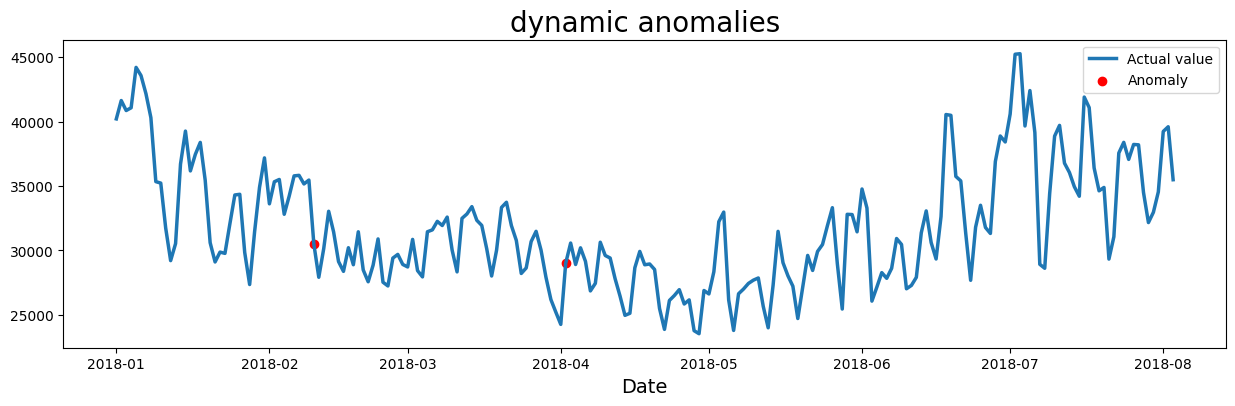

In [15]:
#=================================================-
#### Slide 27: Visualize the anomalies  ####

fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(results['PJME_MW'],markersize = 5, linewidth = 2.5, linestyle = '-', 
        label = 'Actual value')
ax.scatter(results[results['dynamic_anomaly'] == True].index,results[results['dynamic_anomaly'] == True]['PJME_MW'], 
        color='red',label = 'Anomaly')
ax.set_xlabel('Date', fontsize = 14)
ax.set_title("dynamic anomalies", fontsize = 20)
ax.legend()
plt.show()




In [16]:
#=================================================-
#### Slide 29: Add anomaly points  ####

add_anomaly = pjm_energy_datewise.reset_index()
add_anomaly.loc[add_anomaly['Date'] == datetime.date(2018,5,31),'PJME_MW'] = 52000
add_anomaly.loc[add_anomaly['Date'] == datetime.date(2018,2,20),'PJME_MW'] = 50000

add_anomaly = add_anomaly.set_index(['Date'])
arima = ARIMA(add_anomaly, order = (5, 1, 0), freq = 'D')
arima_fit = arima.fit()
predicted = arima_fit.predict(typ='levels')




/Users/swaroopnc/miniforge3/envs/skill_anamoly_2025/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [17]:
#=================================================-
#### Slide 30: Calculate error and dynamic threshold  ####

results = pd.DataFrame(add_anomaly)
results['predicted'] = predicted
results['error'] = abs(results['PJME_MW'] - results['predicted'])

results['error_windowed_mean'] = results['error'].rolling(window=7, min_periods=1).mean()
results['error_windowed_std'] = results['error'].rolling(window=7, min_periods=1).std()
results['dynamic_threshold'] = results['error_windowed_mean'] + (2*results['error_windowed_std'])
results['dynamic_anomaly'] = results['error'] >= results['dynamic_threshold']
results.head()




PJME_MW     predicted         error  error_windowed_mean  \
Date                                                                        
2018-01-01  40202.478261      0.000000  40202.478261         40202.478261   
2018-01-02  41627.333333  35331.891039   6295.442294         23248.960278   
2018-01-03  40852.750000  35703.137189   5149.612811         17215.844455   
2018-01-04  41065.000000  35895.224811   5169.775189         14204.327139   
2018-01-05  44197.791667  37313.696200   6884.095466         12740.280804   

            error_windowed_std  dynamic_threshold  dynamic_anomaly  
Date                                                                
2018-01-01                 NaN                NaN            False  
2018-01-02        23975.895062       71200.750401            False  
2018-01-03        19915.251231       57046.346917            False  
2018-01-04        17340.370063       48885.067264            False  
2018-01-05        15369.888867       43480.058538            False

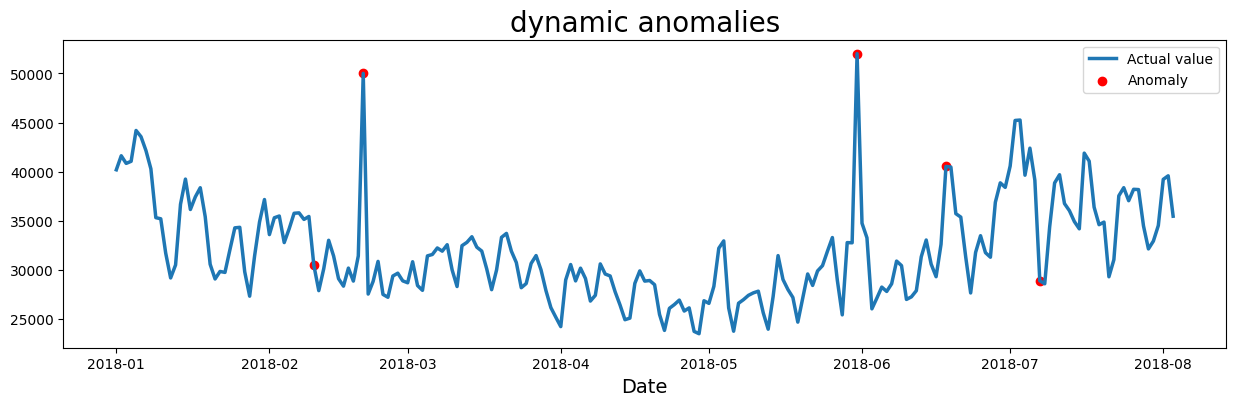

In [18]:
#=================================================-
#### Slide 31: Visualize the anomalies  ####

fig, ax = plt.subplots(figsize = (15, 4))
ax.plot(results['PJME_MW'],markersize = 5, linewidth = 2.5, linestyle = '-', 
        label = 'Actual value')
ax.scatter(results[results['dynamic_anomaly'] == True].index,results[results['dynamic_anomaly'] == True]['PJME_MW'], 
        color='red',label = 'Anomaly')
ax.set_xlabel('Date', fontsize = 14)
ax.set_title("dynamic anomalies", fontsize = 20)
ax.legend()
plt.show()




In [19]:
#=================================================-
#### Slide 34: Exercise 1  ####




#######################################################
####  CONGRATULATIONS ON COMPLETING THIS MODULE!   ####
#######################################################
